# Classification with trees and forests

## Decision Trees


### Overview

Decision tree (DT) is a *non-parametric* supervised method used for both regression and classification. As the name suggests, DTs uses a tree-like model where each internal node rappresent a test on one (or more) attributes of our dataset, and each leaf node rappresent a class label; It follows that the branches rappresent the outcome of our test. The path from root to leaf are the classifications rules.

![A simple rappresentation of a decision tree](imgs/simpleDT.jpg#center)

\
Decision Trees have many advantages such as : 
* Simple to understand and even visualize
* It is a *white box* model; Non parametric approach that is no assumption on the shape/distribution of the data
* Can work with both numerical and categorical values
* Easy train and fast performances



On the other hand decision trees can be very sensitive to small change in the data that can result in major change in the structure of the tree; Another problem with this approach is the danger of overfitting if not taken enough precautions. 



**So the question is how can we can construct a decision tree?**

### The building process: Reducing impurity

The algorithm to build a decision is a 'greedy' algorithm that at each node try to find the variable that **best split** the set of items in each step. So the question becomes what is considered the best split ? 

Two main metrics are used nowdays : 
* Gini impurity 
* Information Gain / Entropy impurity

In this brief project we decided to use the latter.

In general we define the information gain as:   
$$IG(T, \alpha ) = H(T) - H(T| \alpha )$$
where $$H(X) = - \sum^n_{i=1} P(x_i)logP(x_i)$$
is the entropy. 

So when building the decision tree we are trying to reduce the conditional entropy that is equivalent to maximise the information gain on each split. In simple terms we are trying to learn $\alpha$ such that our uncertainty about our observations is minimized. 

So the recursive process will be to begin with the whole dataset in the root node. We then calculate which is the best split among all features and all possible values for that feature; This will leave us with a threshold and feature on where to split. We assign to the left child of the root all observations where it's value is less or equal than the threshold and the rest to the right child. The process in then recursively repeated untill we either have all obs belonging to one class or where there are not enough observations to further split. In both cases those nodes will be the leaf nodes.


For a more Detailed implentation refer to the **DecisionTree\tree.py** python class.

## A little showcase

In [42]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
dF = pd.read_csv('data//csvs//dataframeV1.csv', index_col=0)
dF = dF.drop(['id', 'uri'], axis = 1)
dF.label = pd.Categorical(dF.label)
dF['Y'] = dF.label.cat.codes
dF = dF.drop(['label'], axis = 1)
dF.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Y
0,0.2750,0.1570,7,-18.752,1,0.0636,0.890,0.842,0.186,0.3040,73.289,152280,4,0
1,0.2210,0.1260,0,-25.427,1,0.0447,0.989,0.897,0.102,0.2160,133.630,139307,4,0
2,0.2890,0.0306,9,-30.790,0,0.0446,0.987,0.911,0.102,0.1180,125.610,212067,3,0
3,0.0753,0.0700,2,-27.272,1,0.0440,0.918,0.947,0.146,0.0625,79.801,365147,4,0
4,0.1300,0.1580,2,-16.132,1,0.0350,0.748,0.924,0.100,0.0998,85.031,302093,4,0


In [12]:
from DecisionTree.tree import Tree

# Creating the decision Tree
dT = Tree()

In [13]:
# Prepare the dataset for the decision tree
y = dF.Y 
X = dF.drop(["Y"], axis=1)

# Split in train and validation
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=43, train_size=.75)

In [14]:
# Fit the tree on the train set 
dT.fit(x_train.to_numpy(), y_train.to_numpy())

In [15]:
# Build the prediction over the validation set
preds = dT.predict(x_test.to_numpy())

In [16]:
# Calculate the overall accuracy.
sum(preds == y_test) / len(preds)

0.8872832369942196

# random forest


We now try to address one of the main problems when using DTs, that is overfitting. In fact is common for such models to learn on the noise and small variations in the data, if hyper-paramethers are not carefully tuned. 

A solution to this is to use Random Forests (RF). RF is an **ensamble learning** method that operates by constructing multiple decision trees. Many decision trees are constructed applying the general technique of bootstrapping.

More formally if we have a training set $X = x_1, ..., x_n$ and the labels associated $Y = y_1, ...,y_n$ we **Bag** (Sample with replacment) from $\{X,Y\}$ $ B $ times and train a decision tree on this sample. We then in case of classification take the majority of votes from all the $B$ predictions as the final output of the RF model.

Bootstrapping so help us solve the issue of overfitting. A step further in this direction would be modify the DT algorithm slightly, by looking at each step to only a portion of the features to find the best possible split. This not only improve the overall model accuracy and speed but also provide a further guard against overfitting. 

In [17]:
from RandomForest.randomForest import Forest

So the first question is how many trees should build ? As there is no universal answer the best way to find out this hyperparameter is to use some model selection techniques. 

In [20]:
models = [Forest(max_trees=x) for x in range(3,32+1)]
score = {}
for model in models : 
    model.fit(x_train, y_train)
    score[model.get_max_trees] = model.score(x_test.to_numpy(), y_test.to_numpy())
    print(f"{model.get_max_trees()}", end = '\r')

# This took almost 5 min so i saved the output in 'cv_score.txt'

In [33]:
with open('cv_score.txt', 'r') as f : 
    scores = [l.strip() for l in f.readlines()]
    scores = np.asarray(scores, dtype=np.float32)
    f.close()

(0.0, 32.0)

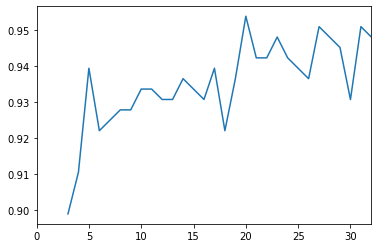

In [51]:
sns.lineplot(x = range(3,32+1), y=scores )
plt.xlim(0,32)

As wee can see there is no clear elbow. We can see tho that only with 5 models we are at around 94% accuracy. This result is good enough to accept the tradeooff of performance.